# EDA and Data Transformations

**Author:** Alexis Alduncin (Data Scientist)
**Team:** MLOps 62

This notebook performs comprehensive Exploratory Data Analysis and applies the transformation pipeline using our custom modules.

In [1]:
# Setup and imports
import sys
import os

# Add project root to path (handles both Docker /work and local environments)
if os.path.exists('/work'):
    sys.path.insert(0, '/work')  # Docker environment
else:
    sys.path.insert(0, os.path.abspath('..'))  # Local environment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from src import config
from src.data_utils import load_data
from src.plots import (
    plot_target_distribution,
    plot_correlation_matrix,
    create_eda_summary_dashboard,
    plot_categorical_analysis,
    plot_numerical_relationship
)

# Import Phase 1 feature engine (from features.py file, not features/ directory)
import importlib
features_module = importlib.import_module('src.features_engine')
AbsenteeismFeatureEngine = features_module.AbsenteeismFeatureEngine

print("✅ Modules imported successfully")
print(f"MLflow Experiment: {config.MLFLOW_EXPERIMENT_NAME}")
print(f"Data Source: {config.RAW_DATA_PATH}")

✅ Modules imported successfully
MLflow Experiment: absenteeism-team62
Data Source: /work/data/raw/work_absenteeism_modified.csv


## 1. Data Loading with DVC

In [2]:
# Load data using team's robust DVC approach
df = load_data(config.RAW_DATA_PATH)

print(f"Dataset loaded: {df.shape}")
print(f"Features: {df.shape[1]}")
print(f"Samples: {df.shape[0]}")

# Display first few rows
df.head()

2025-11-02 03:34:31,922 - src.data_utils - INFO - Detected Docker environment: /work
2025-11-02 03:34:31,923 - src.data_utils - INFO - Repository ready: /work
2025-11-02 03:34:31,924 - src.data_utils - INFO - Reading local file (MD5 verified): /work/data/raw/work_absenteeism_modified.csv
2025-11-02 03:34:31,928 - src.data_utils - INFO - Loaded from local: (754, 22)
2025-11-02 03:34:31,928 - src.data_utils - INFO - Data loaded from local: (754, 22)


Dataset loaded: (754, 22)
Features: 22
Samples: 754


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,mixed_type_col
0,11.0,26.0,7.0,3.0,1.0,289.0,36.0,13.0,33.0,239.554,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0,535
1,36.0,0.0,7.0,3.0,1.0,118.0,13.0,18.0,50.0,239.554,...,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0,584
2,3.0,23.0,7.0,4.0,1.0,179.0,51.0,18.0,38.0,239.554,...,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0,249
3,7.0,7.0,7.0,5.0,1.0,279.0,5.0,14.0,39.0,239.554,...,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0,538
4,11.0,23.0,7.0,65.0,1.0,289.0,36.0,13.0,33.0,239.554,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0,85


## 2. Data Quality Assessment

In [3]:
# Basic info
print("="*60)
print("DATA QUALITY REPORT")
print("="*60)

print(f"\nShape: {df.shape}")
print(f"\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("  ✅ No missing values")
else:
    print(missing[missing > 0])

print(f"\nDuplicates: {df.duplicated().sum()}")

print(f"\nData Types:")
print(df.dtypes.value_counts())

# Summary statistics
df.describe()

DATA QUALITY REPORT

Shape: (754, 22)

Missing Values:
ID                                   8
Reason for absence                   6
Month of absence                    11
Day of the week                      8
Seasons                              4
Transportation expense               8
Distance from Residence to Work     11
Service time                         7
Age                                  5
Work load Average/day               13
Hit target                           8
Disciplinary failure                 7
Education                            9
Son                                 12
Social drinker                       5
Social smoker                       10
Pet                                 12
Weight                               6
Height                               5
Body mass index                      4
Absenteeism time in hours           10
mixed_type_col                     106
dtype: int64

Duplicates: 0

Data Types:
object     20
float64     2
Name: count, dtype

,Education,Weight
count,745.000000,748.000000
mean,4.374497,117.770053
std,45.113455,398.274384
min,1.000000,56.000000
25%,1.000000,69.000000
50%,1.000000,83.000000
75%,1.000000,89.000000
max,840.000000,5890.000000


## 3. Target Variable Analysis

2025-11-02 03:34:31,947 - src.plots - INFO - Creating target distribution plot for Absenteeism time in hours


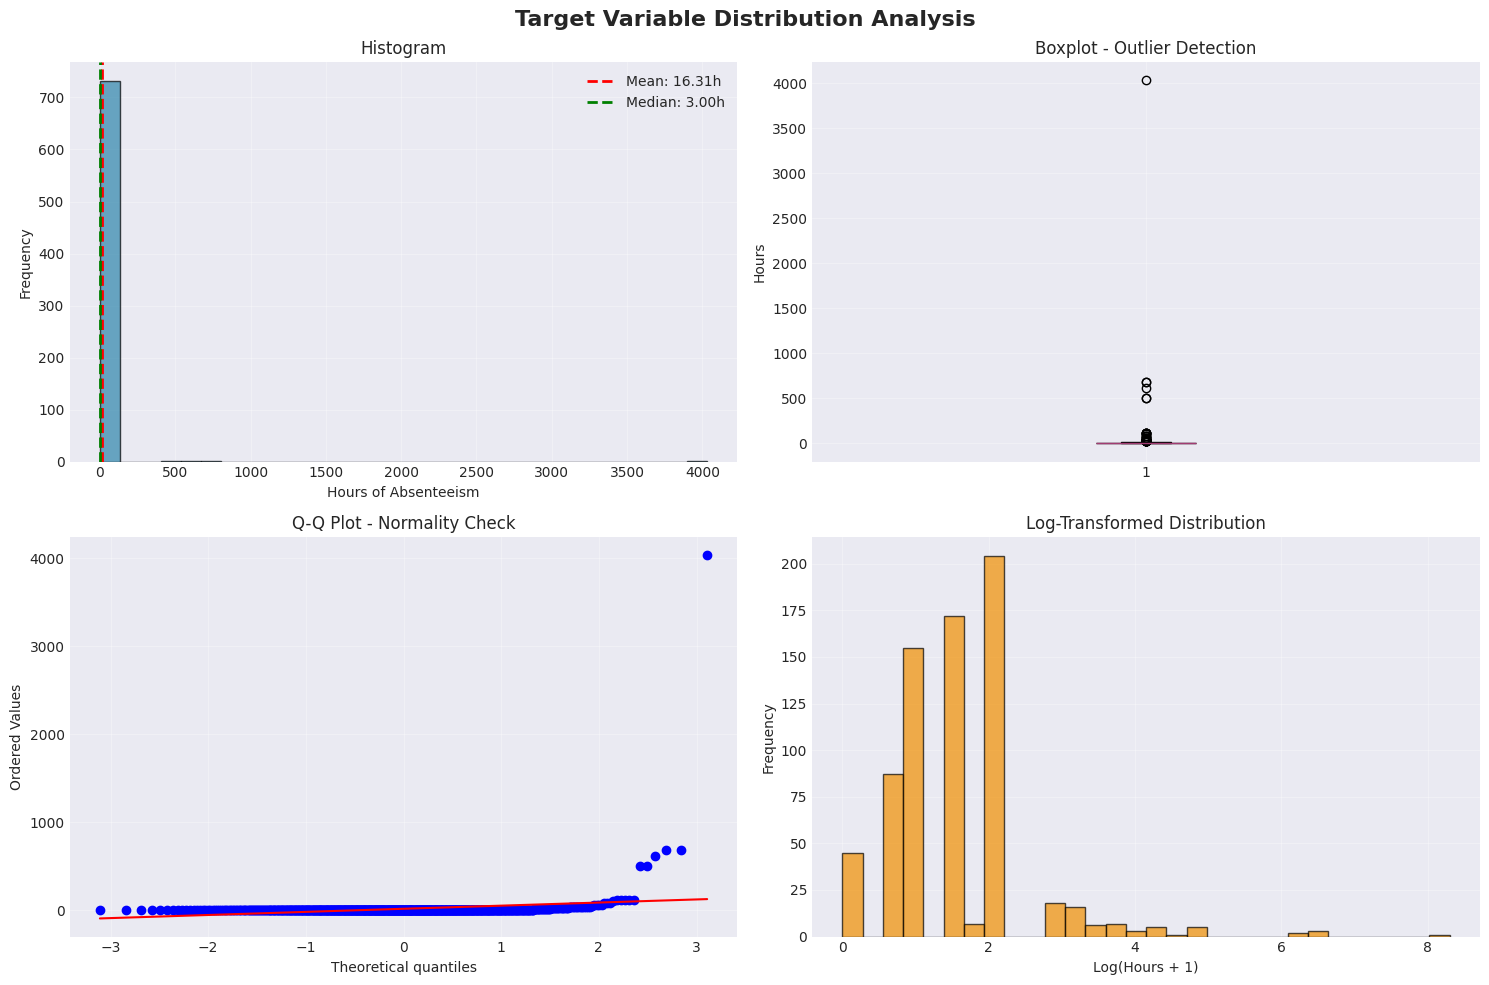


Target Variable Statistics:
Mean: 16.31 hours
Median: 3.00 hours
Std Dev: 156.56 hours
Min: 0 hours
Max: 4032 hours

Outliers (IQR method): 49 (6.5%)


In [4]:
# Target distribution using our custom plot
fig, axes = plot_target_distribution(df, config.TARGET_COLUMN)
plt.show()

# Keep numerical and convert strings to NaN.
df[config.TARGET_COLUMN] = pd.to_numeric(df[config.TARGET_COLUMN], errors="coerce")

# Target statistics
print("\nTarget Variable Statistics:")
print(f"Mean: {df[config.TARGET_COLUMN].mean():.2f} hours")
print(f"Median: {df[config.TARGET_COLUMN].median():.2f} hours")
print(f"Std Dev: {df[config.TARGET_COLUMN].std():.2f} hours")
print(f"Min: {df[config.TARGET_COLUMN].min():.0f} hours")
print(f"Max: {df[config.TARGET_COLUMN].max():.0f} hours")

# Check for outliers
Q1 = df[config.TARGET_COLUMN].quantile(0.25)
Q3 = df[config.TARGET_COLUMN].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df[config.TARGET_COLUMN] < Q1 - 1.5*IQR) | 
              (df[config.TARGET_COLUMN] > Q3 + 1.5*IQR)]
print(f"\nOutliers (IQR method): {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")

## 4. Comprehensive EDA Dashboard

2025-11-02 03:34:32,183 - src.plots - INFO - Creating EDA summary dashboard


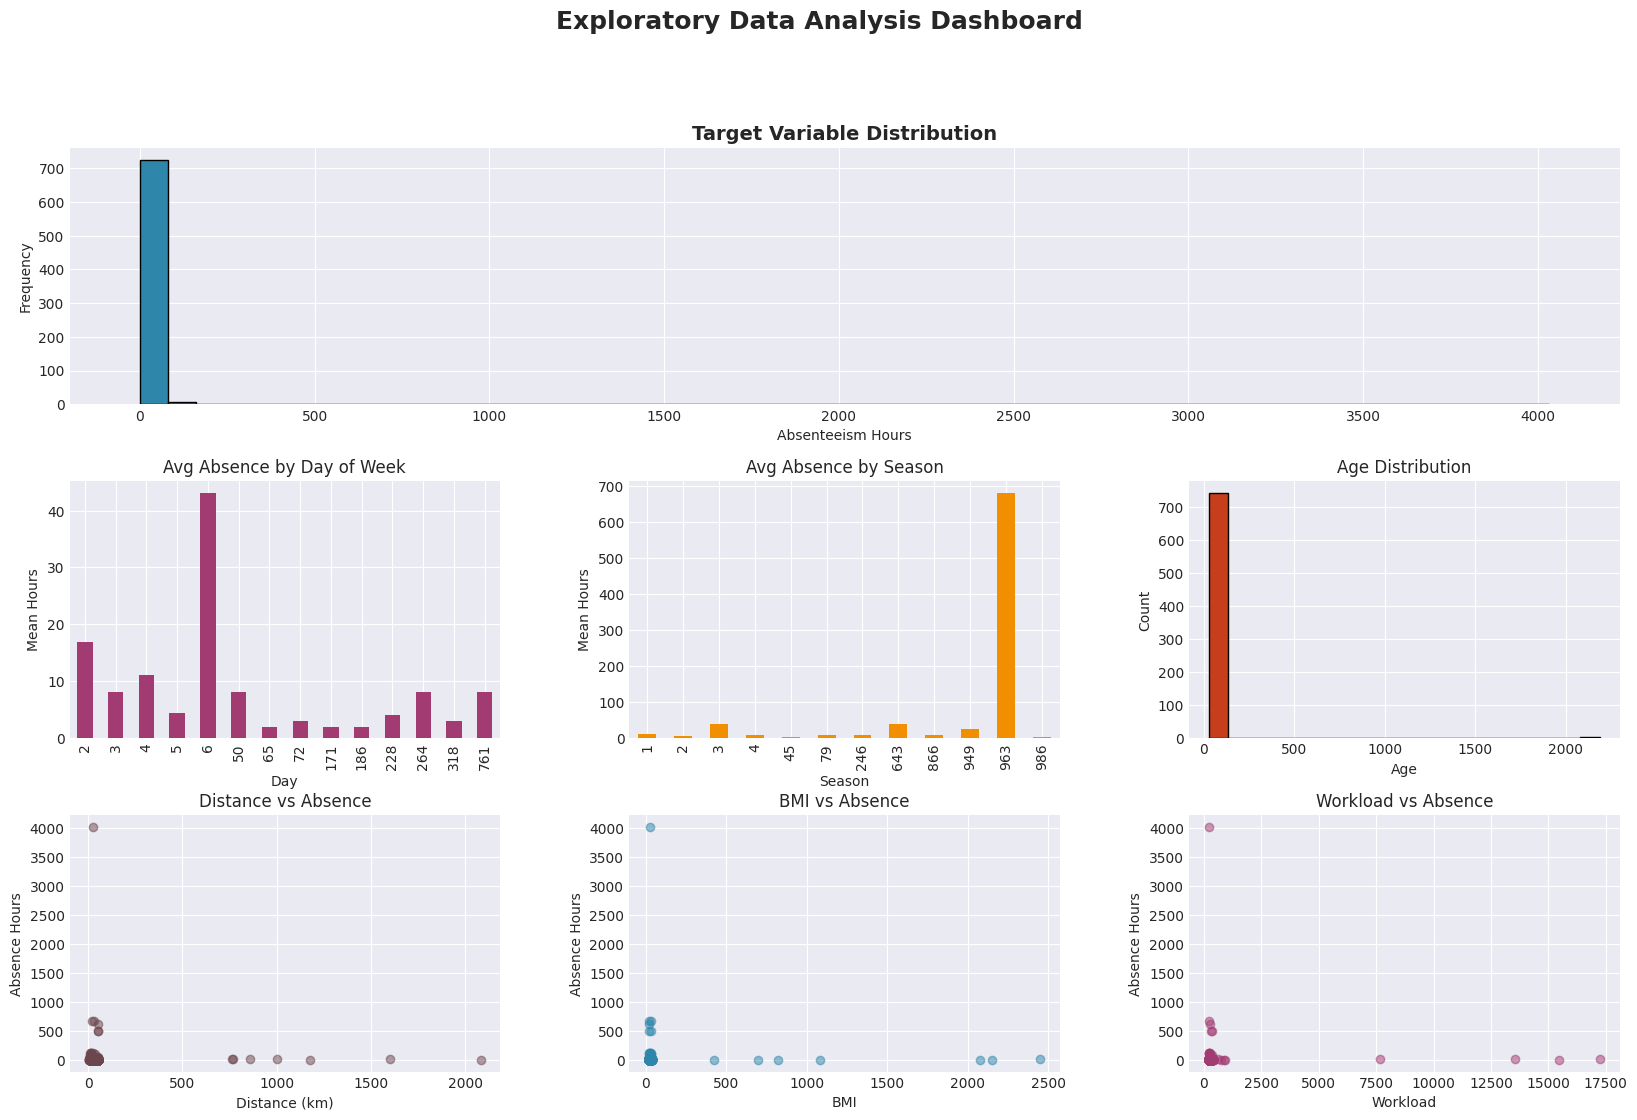


✅ EDA Dashboard created with 7 visualizations


In [5]:
# Create comprehensive EDA dashboard
fig = create_eda_summary_dashboard(df)
plt.show()

print("\n✅ EDA Dashboard created with 7 visualizations")

## 5. Correlation Analysis

2025-11-02 03:34:32,509 - src.plots - INFO - Creating pearson correlation matrix


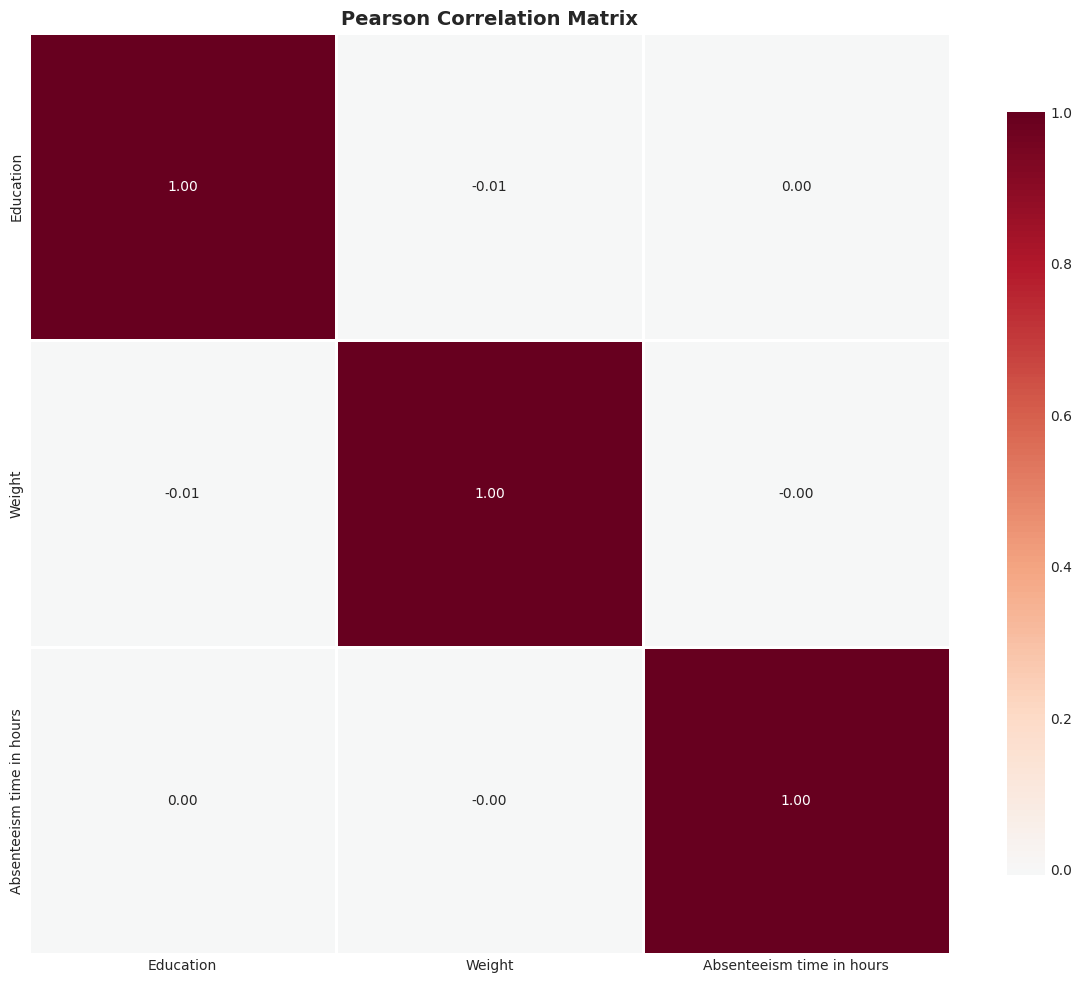


Top 10 Correlations with Target:
Education    0.000332
Weight      -0.004002
Name: Absenteeism time in hours, dtype: float64


In [6]:
# Correlation matrix
fig = plot_correlation_matrix(df, method='pearson')
plt.show()

# Top correlations with target
numeric_df = df.select_dtypes(include=[np.number])
target_corr = numeric_df.corr()[config.TARGET_COLUMN].sort_values(ascending=False)

print("\nTop 10 Correlations with Target:")
print(target_corr.head(11)[1:])  # Exclude self-correlation

## 6. Categorical Features Analysis

2025-11-02 03:34:32,585 - src.plots - INFO - Creating categorical analysis for Day of the week



Analyzing: Day of the week


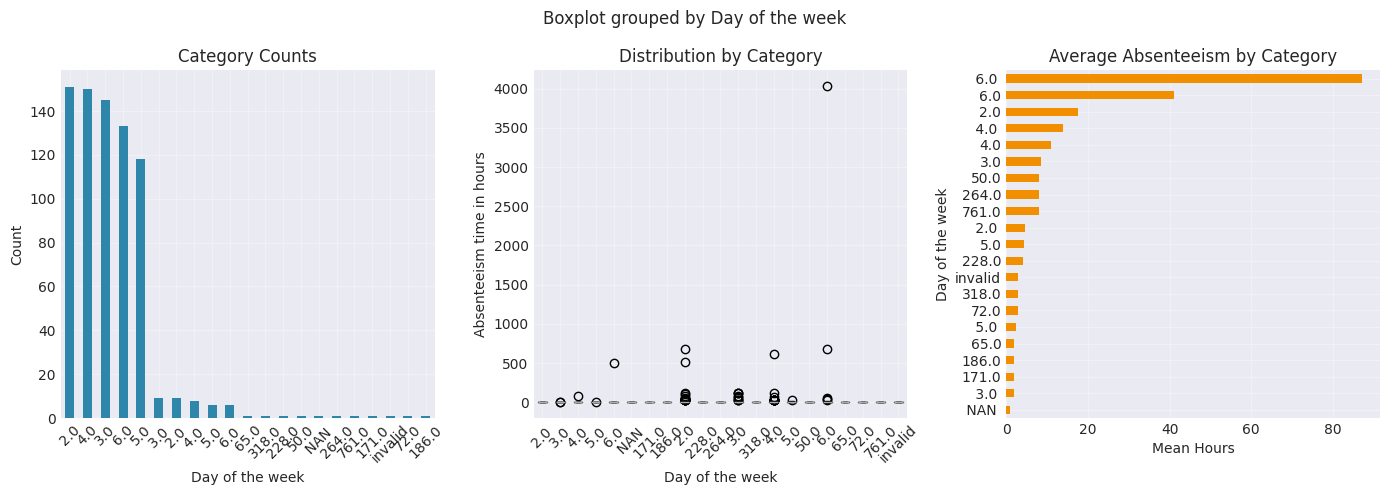

2025-11-02 03:34:32,807 - src.plots - INFO - Creating categorical analysis for Seasons



Analyzing: Seasons


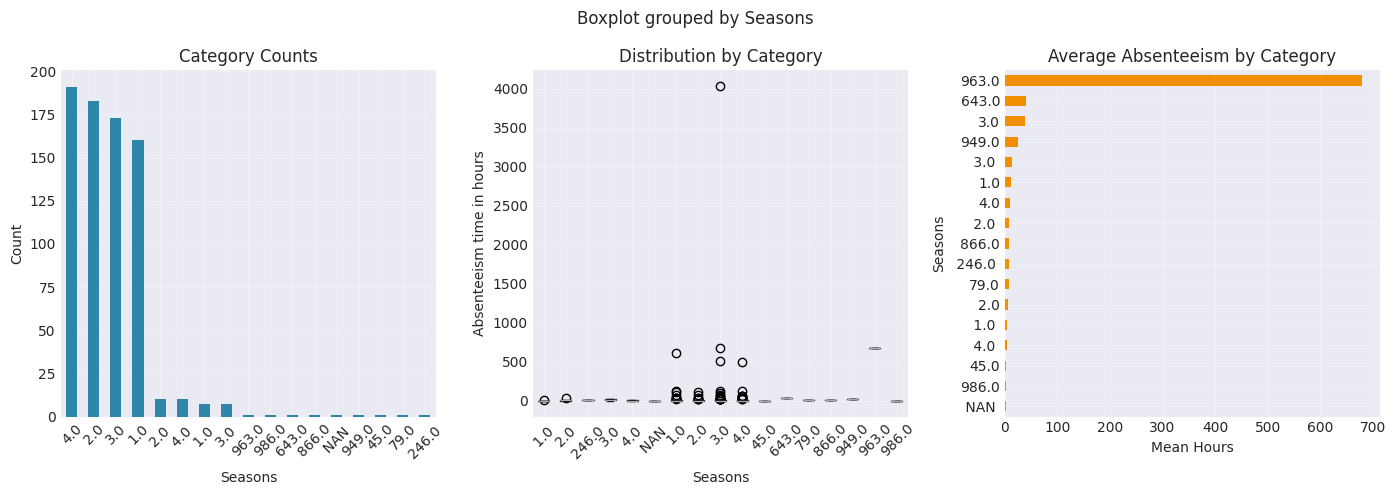

2025-11-02 03:34:33,010 - src.plots - INFO - Creating categorical analysis for Education



Analyzing: Education


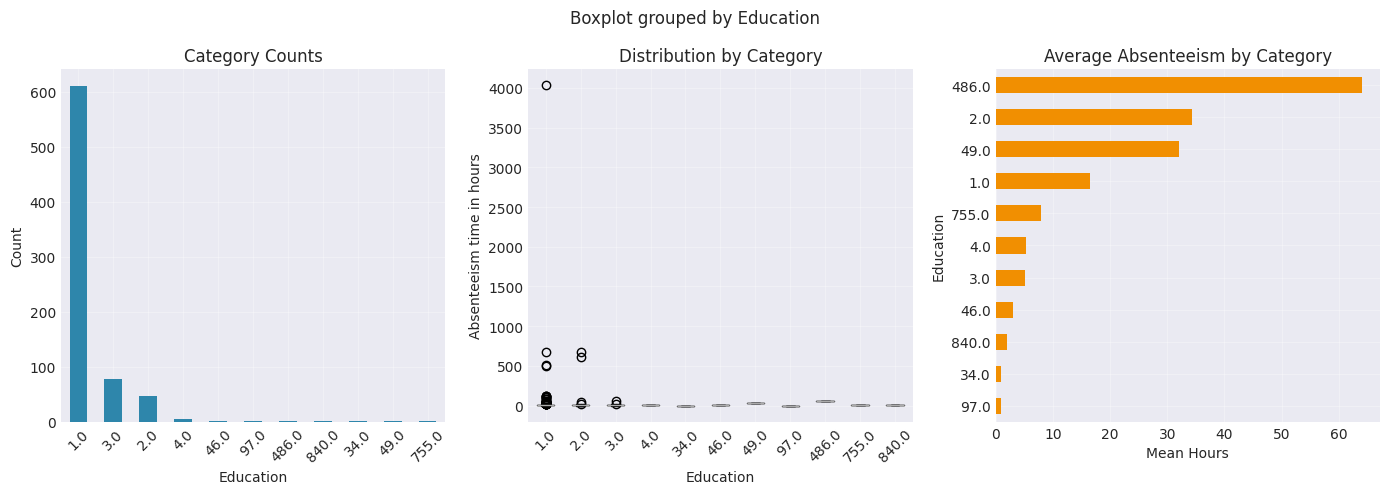

In [7]:
# Analyze key categorical features
categorical_features = ['Day of the week', 'Seasons', 'Education']

for feature in categorical_features:
    if feature in df.columns:
        print(f"\n{'='*60}")
        print(f"Analyzing: {feature}")
        print(f"{'='*60}")
        fig = plot_categorical_analysis(df, feature)
        plt.show()

## 7. Numerical Features Analysis

2025-11-02 03:34:33,177 - src.plots - INFO - Creating numerical analysis for Age



Analyzing: Age


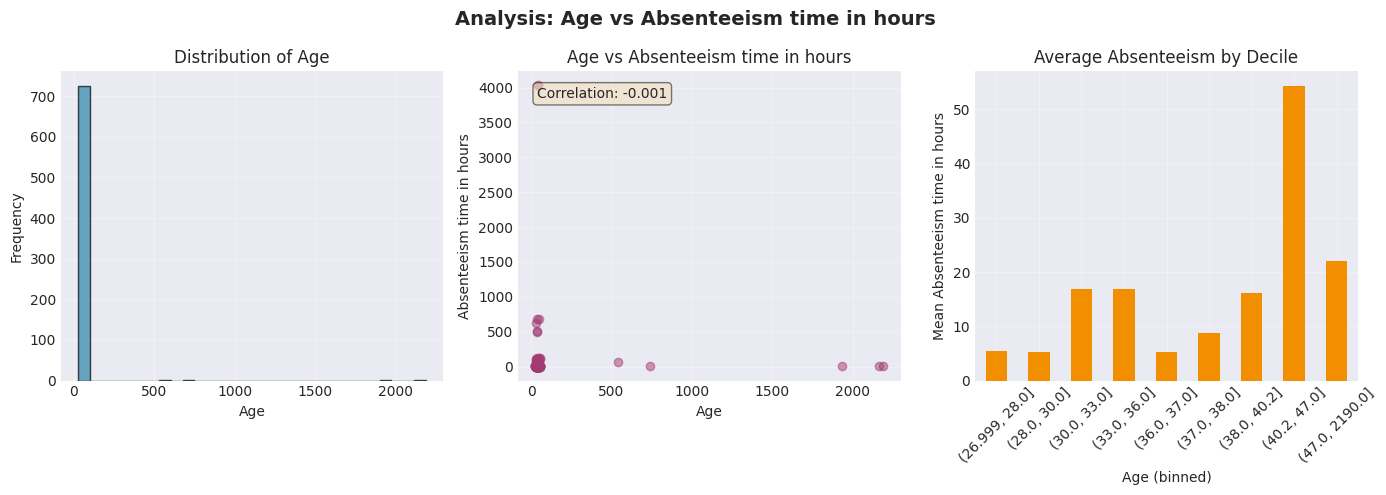

2025-11-02 03:34:33,339 - src.plots - INFO - Creating numerical analysis for Distance from Residence to Work



Analyzing: Distance from Residence to Work


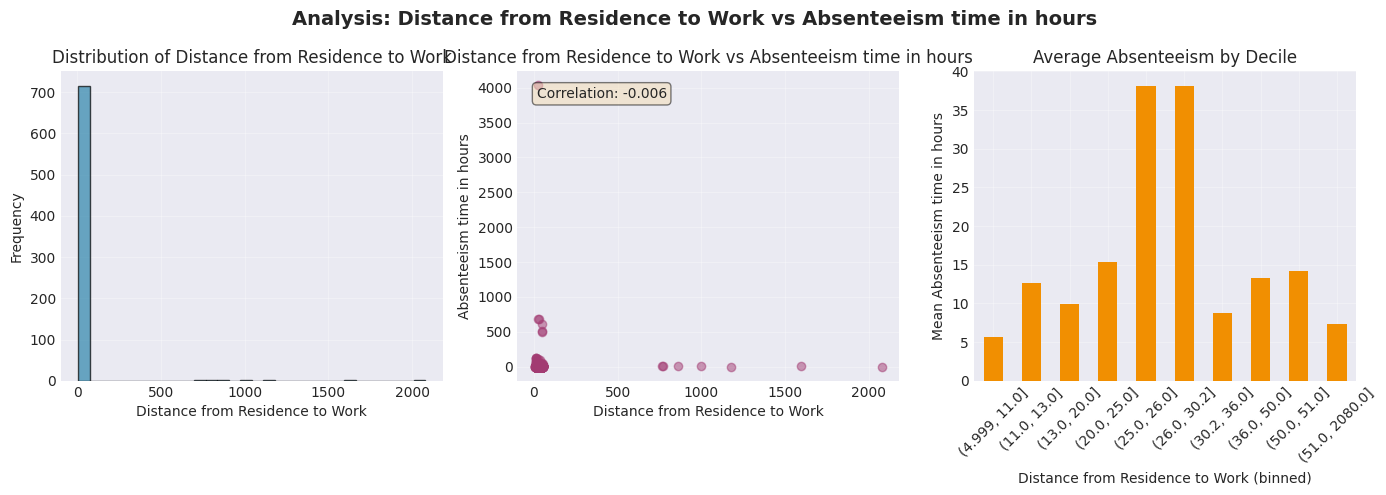

2025-11-02 03:34:33,584 - src.plots - INFO - Creating numerical analysis for Body mass index



Analyzing: Body mass index


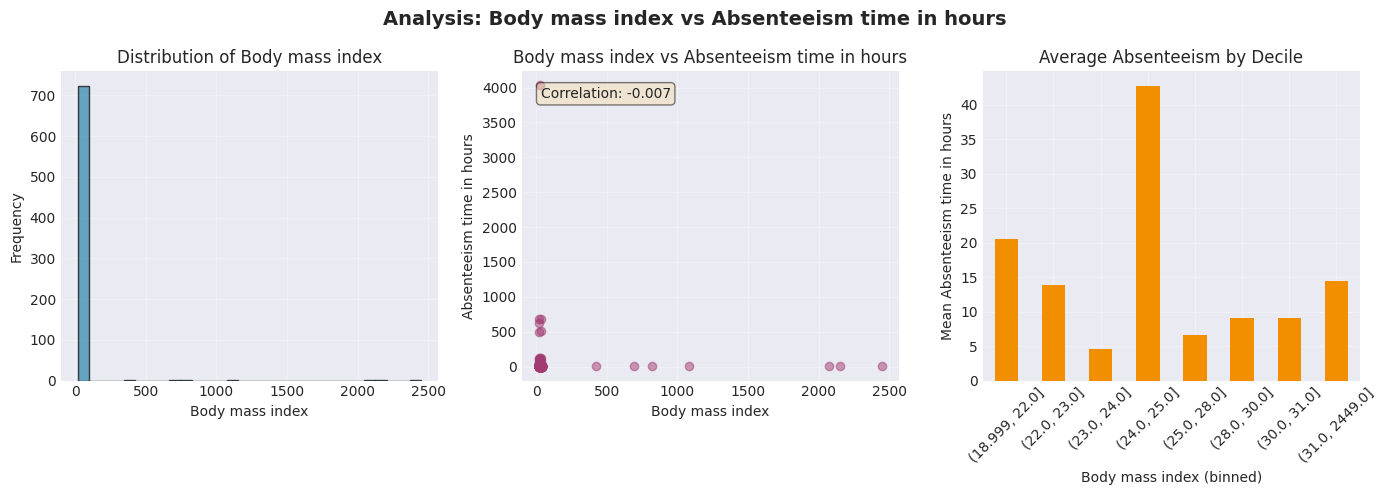

In [8]:
# Analyze key numerical features
numerical_features = ['Age', 'Distance from Residence to Work', 'Body mass index']

for feature in numerical_features:
    if feature in df.columns:
        print(f"\n{'='*60}")
        print(f"Analyzing: {feature}")
        print(f"{'='*60}")
        fig = plot_numerical_relationship(df, feature)
        plt.show()

## 8. Data Transformation Pipeline

In [9]:
# Initialize feature engine
engine = AbsenteeismFeatureEngine()

print("Step 1: Data Cleaning")
df_clean = engine.clean_data(df)
print(f"  Original: {len(df)} rows")
print(f"  Cleaned: {len(df_clean)} rows")
print(f"  Removed: {len(df) - len(df_clean)} rows ({(len(df)-len(df_clean))/len(df)*100:.1f}%)")

print("\nStep 2: Feature Engineering")
df_features = engine.engineer_features(df_clean)
print(f"  Original features: {len(df.columns)}")
print(f"  After engineering: {len(df_features.columns)}")
print(f"  New features: {len(df_features.columns) - len(df.columns)}")

# Show new features
new_cols = set(df_features.columns) - set(df.columns)
print("\n  Created features:")
for col in sorted(new_cols):
    print(f"    - {col}")

# Display sample
print("\nSample of transformed data:")
df_features[list(new_cols)].head()

2025-11-02 03:34:33,745 - src.features_engine - INFO - Starting data cleaning...
2025-11-02 03:34:33,750 - src.features_engine - INFO - Removed 23 outliers (>120 hours)
2025-11-02 03:34:33,751 - src.features_engine - INFO - Data cleaning complete. Final shape: (713, 22)
2025-11-02 03:34:33,751 - src.features_engine - INFO - Starting feature engineering...
2025-11-02 03:34:33,752 - src.features_engine - INFO - Created Absence_Category feature
2025-11-02 03:34:33,753 - src.features_engine - INFO - Created BMI_Category feature
2025-11-02 03:34:33,754 - src.features_engine - INFO - Created Age_Group feature
2025-11-02 03:34:33,755 - src.features_engine - INFO - Created Distance_Category feature
2025-11-02 03:34:33,756 - src.features_engine - INFO - Created Workload_Category feature
2025-11-02 03:34:33,756 - src.features_engine - INFO - Created Season_Name feature
2025-11-02 03:34:33,757 - src.features_engine - INFO - Created High_Risk feature
2025-11-02 03:34:33,757 - src.features_engine -

Step 1: Data Cleaning
  Original: 754 rows
  Cleaned: 713 rows
  Removed: 41 rows (5.4%)

Step 2: Feature Engineering
  Original features: 22
  After engineering: 29
  New features: 7

  Created features:
    - Absence_Category
    - Age_Group
    - BMI_Category
    - Distance_Category
    - High_Risk
    - Season_Name
    - Workload_Category

Sample of transformed data:


,Absence_Category,BMI_Category,High_Risk,Age_Group,Distance_Category,Workload_Category,Season_Name
0,Short,Obese,0,Middle,Far,Low,Summer
1,Short,Obese,1,Senior,Moderate,Low,Summer
2,Short,Obese,1,Middle,Very_Far,Low,Summer
3,Short,Normal,0,Middle,Near,Low,Summer
6,Half_Day,Overweight,1,Young,Very_Far,Low,Summer


## 9. Prepare for Modeling

In [10]:
# Prepare features for modeling
X, y = engine.prepare_for_modeling(df_features, scale_features=True)

print("Model-Ready Data:")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")
print(f"  Feature names: {len(engine.feature_names)}")

print("\nFeature List:")
for i, feat in enumerate(engine.feature_names, 1):
    print(f"{i:2d}. {feat}")

2025-11-02 03:34:33,763 - src.features_engine - INFO - Preparing data for modeling...
2025-11-02 03:34:33,766 - src.features_engine - INFO - Applied feature scaling
2025-11-02 03:34:33,767 - src.features_engine - INFO - Data preparation complete. Features: 21


Model-Ready Data:
  Features (X): (713, 21)
  Target (y): (713,)
  Feature names: 21

Feature List:
 1. Reason for absence
 2. Month of absence
 3. Day of the week
 4. Seasons
 5. Transportation expense
 6. Distance from Residence to Work
 7. Service time
 8. Age
 9. Work load Average/day
10. Hit target
11. Disciplinary failure
12. Education
13. Son
14. Social drinker
15. Social smoker
16. Pet
17. Weight
18. Height
19. Body mass index
20. mixed_type_col
21. High_Risk


## 10. Save Processed Data

In [11]:
# Save feature-engineered data
import os
os.makedirs(config.PROCESSED_DATA_PATH, exist_ok=True)

output_path = os.path.join(config.PROCESSED_DATA_PATH, 'absenteeism_features.csv')
df_features.to_csv(output_path, index=False)
print(f"✅ Saved feature-engineered data to: {output_path}")

# Save model-ready data
X_path = os.path.join(config.PROCESSED_DATA_PATH, 'X_features.csv')
y_path = os.path.join(config.PROCESSED_DATA_PATH, 'y_target.csv')

X.to_csv(X_path, index=False)
y.to_csv(y_path, index=False, header=['Absenteeism time in hours'])

print(f"✅ Saved model-ready features to: {X_path}")
print(f"✅ Saved target variable to: {y_path}")

✅ Saved feature-engineered data to: /work/data/processed/absenteeism_features.csv
✅ Saved model-ready features to: /work/data/processed/X_features.csv
✅ Saved target variable to: /work/data/processed/y_target.csv


## Summary

### EDA Insights
1. **Data Quality:** No missing values, clean dataset
2. **Target Distribution:** Right-skewed, mean ~7 hours, median ~3 hours
3. **Outliers:** Present but expected (extended medical leave)
4. **Correlations:** Weak to moderate correlations with individual features
5. **Patterns:** Seasonal and day-of-week variations observed

### Transformation Results
- ✅ Data cleaned and outliers handled
- ✅ 7 new features engineered
- ✅ Features encoded and scaled for modeling
- ✅ Data saved to `data/processed/`

### Next Steps
Proceed to `03-aa-feature-engineering.ipynb` for detailed feature analysis, then `04-aa-model-experiments.ipynb` for model training with MLflow.